L'objectif de ce Notebook est de comprendre comment les coureurs gèrent leur course : départ rapide, gestion constante, etc.. Evidemment cette mesre individuelle de la gestion de course ne peut se faire qu'en la comparant à la gestion des autres participants, dans le contexte particulier d'une course

In [1]:
#general package
import os
import csv

#data package
import pandas as pd
import numpy as np

#machine learning package
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

#graph package
import matplotlib.pyplot as plt
import seaborn as sns

## Données

test sur utmb 2017

In [2]:
os.listdir('clean_data')

['2003-utmb.csv',
 '2004-utmb.csv',
 '2005-utmb.csv',
 '2006-utmb.csv',
 '2007-utmb.csv',
 '2008-utmb.csv',
 '2009-utmb.csv',
 '2011-utmb.csv',
 '2012-utmb.csv',
 '2013-utmb.csv',
 '2014-utmb.csv',
 '2015-utmb.csv',
 '2016-utmb.csv',
 '2017-utmb.csv']

In [3]:
path = os.path.join('clean_data', '2017-utmb.csv')

In [4]:
data = pd.read_csv(path)

In [5]:
data.head()

,Unnamed: 0,bib,name,team,category,rank,nationality,time,Delevret,St-Gervais,...,La Fouly,Champex La,La Giète,Trient,Les Tseppe,Vallorcine,Col Montet,Flégère,Arrivée,timediff
0,0,4,D'HAENE François,Salomon,SEH,1,FR,68514.0,4310.0,6305.0,...,43466.0,48260.0,53705.0,55499.0,57977.0,60673.0,62402.0,66189.0,68514.0,0.0
1,1,2,JORNET BURGADA Kilian,Salomon,SEH,2,ES,69419.0,4200.0,6261.0,...,43960.0,48832.0,54786.0,56482.0,58996.0,61514.0,63261.0,67167.0,69419.0,905.0
2,2,14,TOLLEFSON Tim,Hoka,SEH,3,US,71580.0,4524.0,6518.0,...,45972.0,50903.0,56755.0,58320.0,60976.0,63585.0,65343.0,69461.0,71580.0,3066.0
3,3,7,THEVENARD Xavier,Asics,SEH,4,FR,72219.0,4311.0,6308.0,...,46859.0,51764.0,57534.0,59333.0,61955.0,64520.0,66204.0,70084.0,72219.0,3705.0
4,4,1,WALMSLEY Jim,Hoka,SEH,5,US,72698.0,4199.0,6135.0,...,43791.0,50102.0,58263.0,59732.0,62088.0,64323.0,66191.0,70415.0,72698.0,4184.0


In [6]:
data.shape

(2535, 33)

In [7]:
data.Arrivée.isna().sum()

848

In [8]:
data.columns

Index(['Unnamed: 0', 'bib', 'name', 'team', 'category', 'rank', 'nationality',
       'time', 'Delevret', 'St-Gervais', 'Contamines', 'La Balme', 'Bonhomme',
       'Chapieux', 'Col Seigne', 'Lac Combal', 'Mt-Favre', 'Checruit',
       'Courmayeur', 'Bertone', 'Bonatti', 'Arnouvaz', 'Col Ferret',
       'La Fouly', 'Champex La', 'La Giète', 'Trient', 'Les Tseppe',
       'Vallorcine', 'Col Montet', 'Flégère', 'Arrivée', 'timediff'],
      dtype='object')

## Analyse

Principes  :
- Nous séparons la course en deux afin de calculer le pourcentage de temps mis sur la 1ere et la 2nd portion de course pour chaque coureur finisher
- 2 features sont crées : part_1, part_2
- Les features sont normalisées
- Apprentissage non-supervisé (clustering)

On ne prend pas les coureurs qui ne sont pas finishers

In [9]:
fData = data[data.time.notna()]

Dans un premier temps, nous séparons les temps de course au niveau d'une ville temps de passage

In [10]:
splitLoc = 'Courmayeur'

In [11]:
split_1 = fData[splitLoc]
split_2 = fData['time'] - fData[splitLoc]

In [12]:
split_data = pd.concat([split_1, split_2, fData['time']], axis = 1)
split_data.columns = ['split_1', 'split_2', 'total_time']

In [13]:
split_data.head()

,split_1,split_2,total_time
0,28938.0,39576.0,68514.0
1,28969.0,40450.0,69419.0
2,30833.0,40747.0,71580.0
3,31074.0,41145.0,72219.0
4,28714.0,43984.0,72698.0


Calculons la part de temps courue par chaque coureur sur chaque split (en %)

In [14]:
split_data['splitP_1'] = split_data['split_1'] / split_data['total_time'] * 100
split_data['splitP_2'] = split_data['split_2'] / split_data['total_time'] * 100

In [15]:
split_data.head()

,split_1,split_2,total_time,splitP_1,splitP_2
0,28938.0,39576.0,68514.0,42.236623,57.763377
1,28969.0,40450.0,69419.0,41.730650,58.269350
2,30833.0,40747.0,71580.0,43.074881,56.925119
3,31074.0,41145.0,72219.0,43.027458,56.972542
4,28714.0,43984.0,72698.0,39.497648,60.502352


Nous percevons facilement sur ce petit échantillon que chaque coureur ne construit pas sa course de la même manière.

Maintenant, nous normalisons les features splitP_n entre 0 et 100

In [16]:
sc = MinMaxScaler()
sc_split = sc.fit_transform(split_data[['splitP_1', 'splitP_2']])

Nous pouvons visualiser le nuage de point correspondant

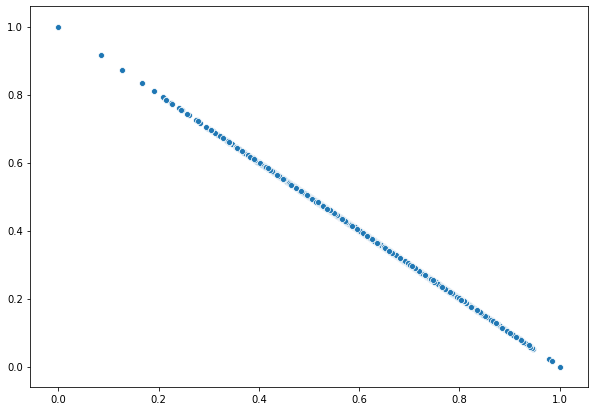

In [17]:
plt.figure(figsize = (10,7))
sns.scatterplot(x= sc_split[:, 0], y = sc_split[:, 1])

Celui-ci ne donne pas assez d'information quant à la distribution des gestions de course. splitP_1 dépendant directement de splitP_2, il est plus approprié d'utilise un diagramme en barre sur une des deux feature

On créé un digramme en bar sur la première feature, pour savoir comment les coureurs ont géré la première partie de coruse

[Text(0, 0.5, 'Densité de coureurs'),
 Text(0.5, 0, 'Part du temps sur la 1ère partie de course')]

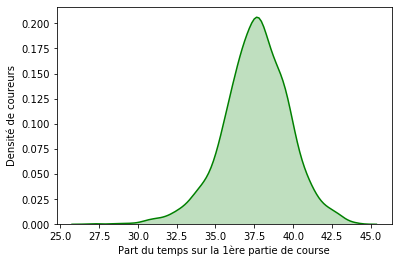

In [18]:
ax = sns.distplot(split_data['splitP_1'], hist=False, color="g", kde_kws={"shade": True})
ax.set(xlabel = 'Part du temps sur la 1ère partie de course', ylabel = 'Densité de coureurs')

En moyenne, la première partie de course prend environ 37.5 % du temps au coureur. On observe une légère queue à gauche. Plus de coureurs tendent à partir vite que l'inverse

De même, nous créons un digramme de densité pour observer la distribution du niveau des coureurs

Nous normalisons les données des temps finaux

In [19]:
sc = MinMaxScaler()
sc_time = sc.fit_transform(np.array(split_data['total_time']).reshape(-1,1))

[Text(0, 0.5, 'Densité de coureurs'), Text(0.5, 0, 'Temps final')]

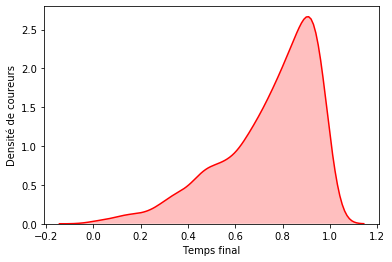

In [20]:
ax = sns.distplot(sc_time.reshape(1,-1)[0], hist = False, color = 'red', kde_kws={"shade": True})
ax.set(xlabel = 'Temps final', ylabel = 'Densité de coureurs')

Sur l'UTMB, la distibution des temps n'est pas normale, le peloton regroupe les moins bons coureurs

Nous pouvons également tenter de voir s'il existe une corrélation entre la gestion de course et le niveau du coureur

<Figure size 720x504 with 0 Axes>

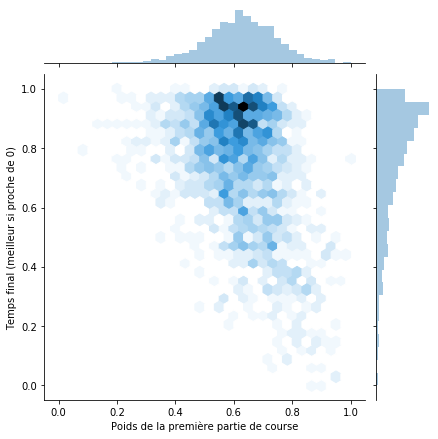

In [21]:
plt.figure(figsize = (10,7))
ax = sns.jointplot(x=sc_split[:, 0] , y=sc_time.reshape(1,-1)[0],kind = 'hex')
ax.set_axis_labels("Poids de la première partie de course", "Temps final (meilleur si proche de 0)")

Nous percevons très clairement que :
- Les meilleurs prennent beaucoup plus de temps (en pourcentage) sur la première partie de course que sur la seconde par rapport à l'ensemble des coureurs
- La capacité à mieux équilibrer sa course est dévolue aux coureurs expérimentés, capables de ne pas s'éfondrer sur la seconde partie de course
- Nous remarquons que tous les coureurs qui ont une première partie de course beaucoup plus rapide que la seconde n'ont pas eu les meilleurs performances
- Le gros du peloton adopte à peu près la même stratégie de course entre la première et la seconde partie de course

- n'oublions pas que cette analyse ne prend pas en compte les personnes abandonnant. Ceux-ci ont pu partir trop vites et exploser. D'autres sont partis moins vites et n'ont pas passé les barières horaires

- Pour résumer : Une première partie gérée avec précaution est nécessaire pour avoir un bon résultat final, mais pas suffisante

## Analyse Etape 2

Nous découpons la course en quatre partie pour savoir si des profils de gesiton de course plus fins se dessinent

In [22]:
splitLoc1 = 'Bonhomme'
splitLoc2 = 'Courmayeur'
splitLoc3 = 'Champex La'

In [23]:
fData

,Unnamed: 0,bib,name,team,category,rank,nationality,time,Delevret,St-Gervais,...,La Fouly,Champex La,La Giète,Trient,Les Tseppe,Vallorcine,Col Montet,Flégère,Arrivée,timediff
0,0,4,D'HAENE François,Salomon,SEH,1,FR,68514.0,4310.0,6305.0,...,43466.0,48260.0,53705.0,55499.0,57977.0,60673.0,62402.0,66189.0,68514.0,0.0
1,1,2,JORNET BURGADA Kilian,Salomon,SEH,2,ES,69419.0,4200.0,6261.0,...,43960.0,48832.0,54786.0,56482.0,58996.0,61514.0,63261.0,67167.0,69419.0,905.0
2,2,14,TOLLEFSON Tim,Hoka,SEH,3,US,71580.0,4524.0,6518.0,...,45972.0,50903.0,56755.0,58320.0,60976.0,63585.0,65343.0,69461.0,71580.0,3066.0
3,3,7,THEVENARD Xavier,Asics,SEH,4,FR,72219.0,4311.0,6308.0,...,46859.0,51764.0,57534.0,59333.0,61955.0,64520.0,66204.0,70084.0,72219.0,3705.0
4,4,1,WALMSLEY Jim,Hoka,SEH,5,US,72698.0,4199.0,6135.0,...,43791.0,50102.0,58263.0,59732.0,62088.0,64323.0,66191.0,70415.0,72698.0,4184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,1682,2270,PELLIER-CUIT Yann,NaN,SEH,1683,FR,165656.0,6314.0,9253.0,...,92099.0,104414.0,122268.0,128913.0,135751.0,145505.0,149736.0,159095.0,165656.0,97142.0
1683,1683,2813,JIANG Cheng,NaN,SEH,1684,CN,165674.0,7496.0,11451.0,...,98425.0,110804.0,125829.0,133592.0,139085.0,145709.0,149020.0,158938.0,165674.0,97160.0
1684,1684,2584,FONTAINE Vincent,AJ AUXERRE MARATHON,V2H,1685,FR,165759.0,7174.0,11341.0,...,99117.0,112376.0,126293.0,132080.0,138125.0,145684.0,149752.0,158895.0,165759.0,97245.0
1685,1685,2161,STANGNES Eirik,NaN,V1H,1686,NO,166420.0,7932.0,11960.0,...,99778.0,112863.0,127999.0,133278.0,138657.0,145385.0,150096.0,158979.0,166420.0,97906.0


In [24]:
split_1 = fData[splitLoc1]
split_2 = fData[splitLoc2] - split_1
split_3 = fData[splitLoc3] - split_1 - split_2
split_4 = fData['time'] - split_1 - split_2 - split_3

In [25]:
split_data = pd.concat([split_1, split_2, split_3, split_4, fData['time'], fData['category']], axis = 1)
split_data.columns = ['split_1', 'split_2', 'split_3', 'split_4', 'total_time', 'category']

In [26]:
split_data.head()

,split_1,split_2,split_3,split_4,total_time,category
0,16087.0,12851.0,19322.0,20254.0,68514.0,SEH
1,16158.0,12811.0,19863.0,20587.0,69419.0,SEH
2,16864.0,13969.0,20070.0,20677.0,71580.0,SEH
3,16686.0,14388.0,20690.0,20455.0,72219.0,SEH
4,16063.0,12651.0,21388.0,22596.0,72698.0,SEH


Calculons la part de temps courue par chaque coureur sur chaque split (en %)

In [27]:
split_data['splitP_1'] = split_data['split_1'] / split_data['total_time'] * 100
split_data['splitP_2'] = split_data['split_2'] / split_data['total_time'] * 100
split_data['splitP_3'] = split_data['split_3'] / split_data['total_time'] * 100
split_data['splitP_4'] = split_data['split_4'] / split_data['total_time'] * 100

In [28]:
split_data.head()

,split_1,split_2,split_3,split_4,total_time,category,splitP_1,splitP_2,splitP_3,splitP_4
0,16087.0,12851.0,19322.0,20254.0,68514.0,SEH,23.479873,18.756750,28.201535,29.561841
1,16158.0,12811.0,19863.0,20587.0,69419.0,SEH,23.276048,18.454602,28.613204,29.656146
2,16864.0,13969.0,20070.0,20677.0,71580.0,SEH,23.559654,19.515228,28.038558,28.886560
3,16686.0,14388.0,20690.0,20455.0,72219.0,SEH,23.104723,19.922735,28.648970,28.323571
4,16063.0,12651.0,21388.0,22596.0,72698.0,SEH,22.095518,17.402129,29.420342,31.082011


Nous vérifions s'il reste des NA

In [29]:
split_data.isna().sum()

split_1       6
split_2       6
split_3       6
split_4       6
total_time    0
category      0
splitP_1      6
splitP_2      6
splitP_3      6
splitP_4      6
dtype: int64

6 coureurs ont un temps final mais n'ont pas de temps intermédiaire, très certainement à ause d'un défaut de puce

Nous supprimons les coureurs qui n'ont pas de chrono sur les points de passage

In [30]:
split_data = split_data[pd.notnull(split_data['splitP_1'])]
split_data = split_data[pd.notnull(split_data['splitP_2'])]
split_data = split_data[pd.notnull(split_data['splitP_3'])]
split_data = split_data[pd.notnull(split_data['splitP_3'])]

In [31]:
split_data.isna().sum()

split_1       0
split_2       0
split_3       0
split_4       0
total_time    0
category      0
splitP_1      0
splitP_2      0
splitP_3      0
splitP_4      0
dtype: int64

In [32]:
split_data

,split_1,split_2,split_3,split_4,total_time,category,splitP_1,splitP_2,splitP_3,splitP_4
0,16087.0,12851.0,19322.0,20254.0,68514.0,SEH,23.479873,18.756750,28.201535,29.561841
1,16158.0,12811.0,19863.0,20587.0,69419.0,SEH,23.276048,18.454602,28.613204,29.656146
2,16864.0,13969.0,20070.0,20677.0,71580.0,SEH,23.559654,19.515228,28.038558,28.886560
3,16686.0,14388.0,20690.0,20455.0,72219.0,SEH,23.104723,19.922735,28.648970,28.323571
4,16063.0,12651.0,21388.0,22596.0,72698.0,SEH,22.095518,17.402129,29.420342,31.082011
...,...,...,...,...,...,...,...,...,...,...
1682,28660.0,27951.0,47803.0,61242.0,165656.0,SEH,17.300913,16.872917,28.856788,36.969382
1683,33307.0,29812.0,47685.0,54870.0,165674.0,SEH,20.103939,17.994374,28.782428,33.119258
1684,32858.0,30547.0,48971.0,53383.0,165759.0,V2H,19.822755,18.428562,29.543494,32.205189
1685,32667.0,29726.0,50470.0,53557.0,166420.0,V1H,19.629251,17.862036,30.326884,32.181829


In [33]:
new_index = list(range(split_data.shape[0]))

In [34]:
split_data.index = new_index

In [88]:
split_data.head()

,split_1,split_2,split_3,split_4,total_time,category,splitP_1,splitP_2,splitP_3,splitP_4
0,16087.0,12851.0,19322.0,20254.0,68514.0,SEH,23.479873,18.756750,28.201535,29.561841
1,16158.0,12811.0,19863.0,20587.0,69419.0,SEH,23.276048,18.454602,28.613204,29.656146
2,16864.0,13969.0,20070.0,20677.0,71580.0,SEH,23.559654,19.515228,28.038558,28.886560
3,16686.0,14388.0,20690.0,20455.0,72219.0,SEH,23.104723,19.922735,28.648970,28.323571
4,16063.0,12651.0,21388.0,22596.0,72698.0,SEH,22.095518,17.402129,29.420342,31.082011


In [36]:
split_data.index 

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680],
           dtype='int64', length=1681)

In [37]:
split_data.head()

,split_1,split_2,split_3,split_4,total_time,category,splitP_1,splitP_2,splitP_3,splitP_4
0,16087.0,12851.0,19322.0,20254.0,68514.0,SEH,23.479873,18.756750,28.201535,29.561841
1,16158.0,12811.0,19863.0,20587.0,69419.0,SEH,23.276048,18.454602,28.613204,29.656146
2,16864.0,13969.0,20070.0,20677.0,71580.0,SEH,23.559654,19.515228,28.038558,28.886560
3,16686.0,14388.0,20690.0,20455.0,72219.0,SEH,23.104723,19.922735,28.648970,28.323571
4,16063.0,12651.0,21388.0,22596.0,72698.0,SEH,22.095518,17.402129,29.420342,31.082011


Nous normalisons les données

In [38]:
sc = MinMaxScaler()
sc_split = sc.fit_transform(split_data[['splitP_1', 'splitP_2', 'splitP_3', 'splitP_4']])

In [39]:
sc_split = pd.DataFrame(sc_split)
sc_split.columns = ['splitP_1', 'splitP_2', 'splitP_3', 'splitP_4']

In [40]:
sc_split.head()

,splitP_1,splitP_2,splitP_3,splitP_4
0,0.851895,0.633580,0.482026,0.115827
1,0.832711,0.601766,0.515203,0.120109
2,0.859405,0.713441,0.468892,0.085168
3,0.816585,0.756348,0.518085,0.059606
4,0.721596,0.490950,0.580251,0.184847


In [41]:
sc_split.shape

(1681, 4)

Nous pouvons tracer le graph intercorrélation entre chaque feature

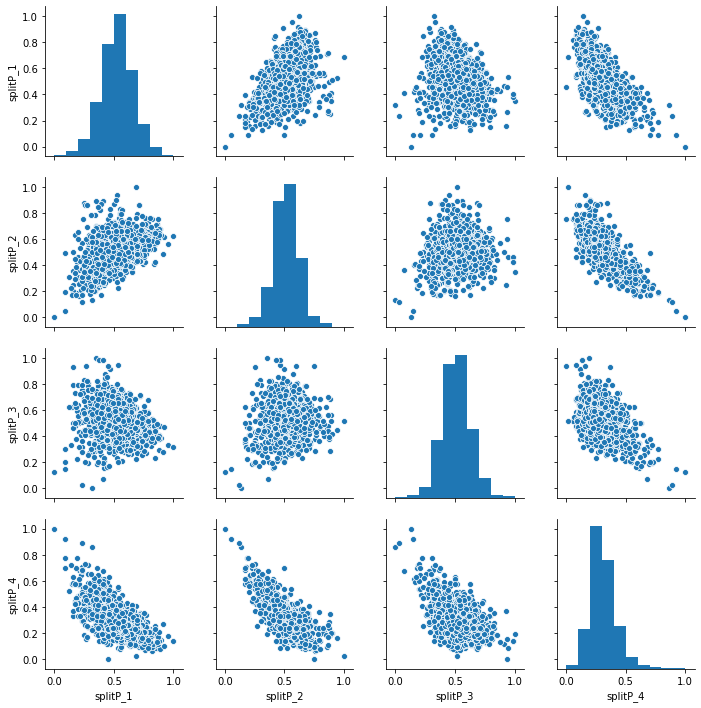

In [42]:
sns.pairplot(sc_split)

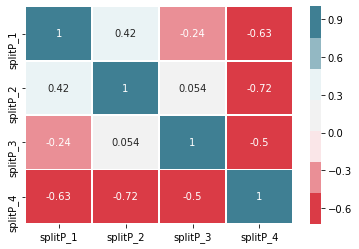

In [43]:
cor = sc_split.corr()
sns.heatmap(cor, annot = True, linewidths=.5, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

Nous remarquons deux éléments très intéressants :
- Les coureurs qui font un début de course (split_1) assez rapide continuent sur leur lancée. Corrélation positive à 0.45
- A l'inverse, les coureurs qui sont partis plus lentement vont plus vite sur la 4eme partie. Le rééquilibrage ne se fait pas sur la partie 3. Corrélation à -0.64 entre splitP_4 et splitP_2

Nous réalisons maintenant une PCA (Principal Component Analysis) pour réduire la dimension de la donnée et pouvoir l'observer en 2D

In [44]:
pca = PCA(n_components = 2)
pca_split = pca.fit_transform(sc_split)

In [45]:
pca_split = pd.DataFrame(data = pca_split, columns = ['principal component 1', 'principal component 2'])

In [46]:
pca_split.head()

,principal component 1,principal component 2
0,-0.378593,0.105176
1,-0.351146,0.072002
2,-0.439627,0.105364
3,-0.453014,0.034566
4,-0.193634,-0.005751


In [47]:
pca_split.shape

(1681, 2)

Nous analysons maintenant le degré de variance de l'ensemble de la donnée initiale que l'on peut retrouver dans les deux composanates principales

In [48]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.54308203 0.32819181]


87% de l'information est contenue dans ces deux composantes principales

In [49]:
pca_split

,principal component 1,principal component 2
0,-0.378593,0.105176
1,-0.351146,0.072002
2,-0.439627,0.105364
3,-0.453014,0.034566
4,-0.193634,-0.005751
...,...,...
1676,0.281588,-0.084293
1677,-0.046433,-0.021899
1678,-0.082041,-0.100612
1679,-0.047279,-0.158434


Nous réalisons désormais un clustering sur ces quatre features

In [50]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

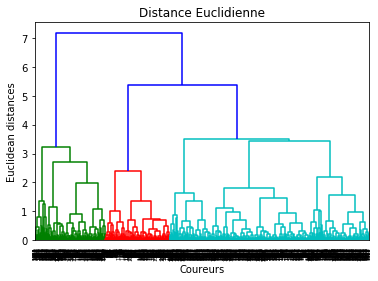

In [51]:
dendrogram = sch.dendrogram(sch.linkage(sc_split, method  = "ward"))
plt.title('Distance Euclidienne')
plt.xlabel('Coureurs')
plt.ylabel('Euclidean distances')
plt.show()

La méthode ward permet de minismer la variance intra cluster

Nous percevons très clairement que la donnée est séparable en trois clusters. Nous allons donc construire un clustering agglomératif à trois clusters

In [52]:
agg = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage='ward')
labels = agg.fit_predict(sc_split)

In [53]:
print(labels)

[2 2 2 ... 0 0 1]


In [54]:
label = pd.DataFrame(labels)
label.columns = ['label']

In [55]:
label.head()

,label
0,2
1,2
2,2
3,2
4,0


In [56]:
len(label)

1681

Nous retracons les deux composantes principales de la PCA en ajoutant le label de chaque point

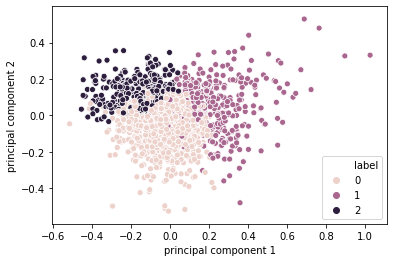

In [57]:
ax = sns.scatterplot(x=pca_split['principal component 1'], y=pca_split['principal component 2'],
                     hue=label['label'])

Pour rappel, notre PCA a conservé 87% de l'information. Nos trois clusters ne forment pas trois nuages de points totalement séparés. Cependant, trois profils distincts se détachent sans trop se confondre

Nous analysons désormais le positionnement de chaque label sur les quatre features initiales

In [58]:
sc_split = pd.concat([sc_split, label], axis = 1)

In [59]:
sc_split = sc_split.rename(columns = {0 : 'label'})

In [60]:
sc_split.head()

,splitP_1,splitP_2,splitP_3,splitP_4,label
0,0.851895,0.633580,0.482026,0.115827,2
1,0.832711,0.601766,0.515203,0.120109,2
2,0.859405,0.713441,0.468892,0.085168,2
3,0.816585,0.756348,0.518085,0.059606,2
4,0.721596,0.490950,0.580251,0.184847,0


In [61]:
sc_split.shape

(1681, 5)

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


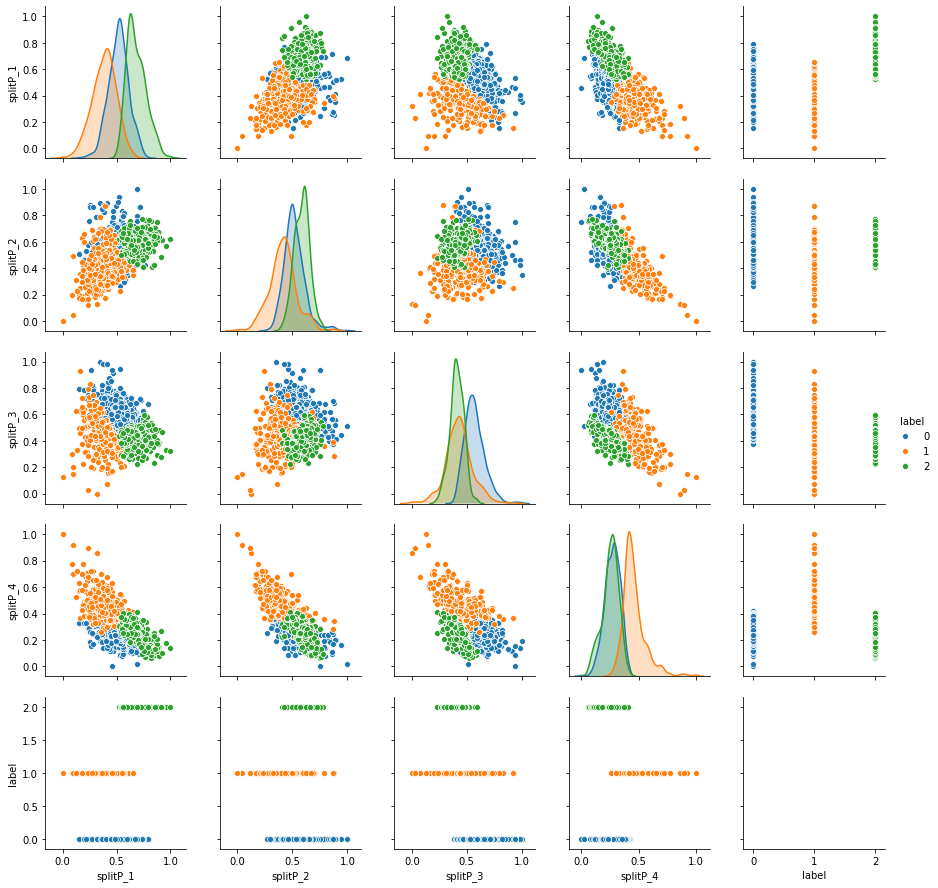

In [62]:
sns.pairplot(sc_split, hue = 'label')

- Profil bleu : Coureur ayant tendance à partir assez vite sur le début de course
- Profil orange : Coureur fléchissant petit à petit mais auteur d'une bonne fin de course
- Profil vert : Coureur lissant son effort au maximum en ne partant pas trop vite et auteur d'une bonne fin de course

Nous calculons le centre de chaque cluster afin de caractériser le cluster (calcul des variables T1, T2, T3 et T4)

In [66]:
profil = pd.concat([split_data[['splitP_1', 'splitP_2', 'splitP_3', 'splitP_4']], label['label']], axis = 1)

In [67]:
profil.head()

,splitP_1,splitP_2,splitP_3,splitP_4,label
0,23.479873,18.756750,28.201535,29.561841,2
1,23.276048,18.454602,28.613204,29.656146,2
2,23.559654,19.515228,28.038558,28.886560,2
3,23.104723,19.922735,28.648970,28.323571,2
4,22.095518,17.402129,29.420342,31.082011,0


In [70]:
profil.groupby(['label']).mean().T

label,0,1,2
splitP_1,19.956371,18.536159,21.722132
splitP_2,17.692303,16.718790,18.336231
splitP_3,29.332155,27.570286,27.325134
splitP_4,33.019172,37.174765,32.616503


In [71]:
sc = MinMaxScaler()
sc_profil = sc.fit_transform(profil.groupby(['label']).mean())

In [74]:
dfProfil = pd.DataFrame(data = sc_profil.T, columns = list(profil.label.unique()))

In [75]:
dfProfil = 1 - dfProfil

In [76]:
dfProfil.index = ['Départ', 'Bonhomme', 'Courmayeur', 'Champex La']

In [77]:
dfProfil.head()

,2,0,1
Départ,0.554230,1.000000e+00,0.0
Bonhomme,0.398115,1.000000e+00,0.0
Courmayeur,0.000000,8.778528e-01,1.0
Champex La,0.911662,8.881784e-16,1.0


In [78]:
sns.set(style="darkgrid")

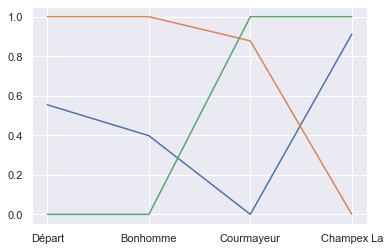

In [79]:
plt.plot(dfProfil)

Nous comparons ces profils au temps mis pour boucler le parcours

In [80]:
time_label = pd.DataFrame()
time_label['time'] = split_data['total_time']
time_label['label'] = sc_split['label']

In [81]:
time_label.head()

,time,label
0,68514.0,2
1,69419.0,2
2,71580.0,2
3,72219.0,2
4,72698.0,0


<Figure size 864x576 with 0 Axes>

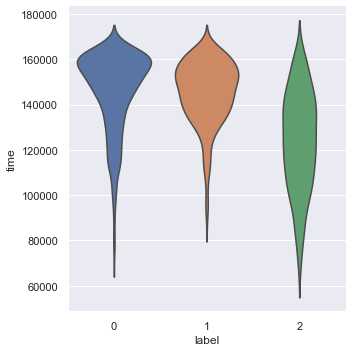

In [82]:
#plt.figure(figsize = (5,5))
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.catplot(x = 'label', y = 'time', kind = 'violin', inner = None, data = time_label)

Il est ainsi clair que les meilleurs sont ceux qui arrivent à lisser leur effort au mieux (sans partir trop vite, pour faire une bonne fin de course)

Cepedant, le gros du peloton n'utilise pas forcément la stratégie bleue volontairement. L'épreuve est assez dure pour fléchir petit à petit sans le vouloir malgré un départ prudent...

In [83]:
ones = np.ones(time_label.shape[0])
time_cat = pd.concat([split_data.category, time_label.label, pd.DataFrame(ones)], axis = 1)


time_cat.head()

,category,label,0
0,SEH,2,1.0
1,SEH,2,1.0
2,SEH,2,1.0
3,SEH,2,1.0
4,SEH,0,1.0


Répartition des profils sur l'ensemble du peloton

<Figure size 864x576 with 0 Axes>

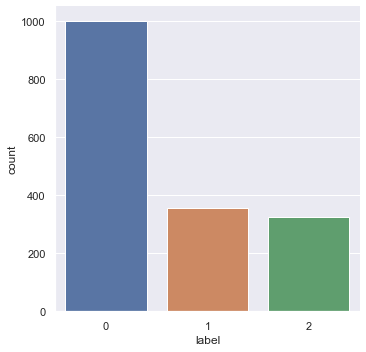

In [84]:
#plt.figure(figsize = (5,5))
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.catplot("label", 
                data=time_cat,
                kind="count")


Répartition des profils parmi les cents premiers

<Figure size 864x576 with 0 Axes>

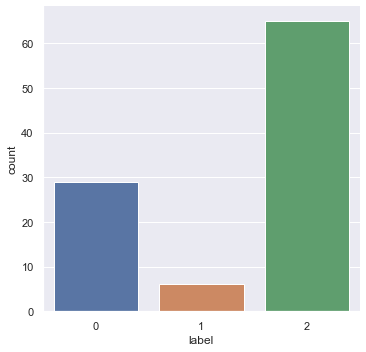

In [85]:
#Pour les 100 premiers
#plt.figure(figsize = (5,5))
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.catplot("label", 
                data=time_cat.iloc[:100,:],
                kind="count")


In [86]:
time_cat.groupby(['category', 'label'])

Enfin, nous pouvons comparer le profil de course privilégié par chaque catagorie

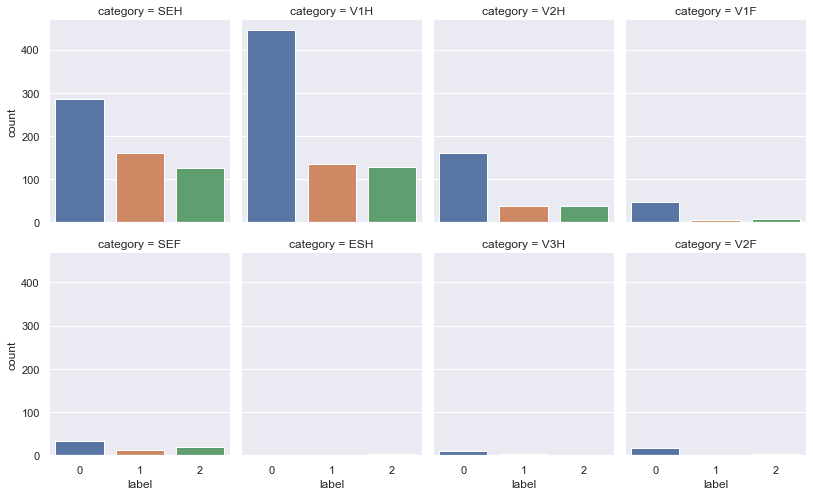

In [87]:
g = sns.catplot("label", col="category", col_wrap=4,
                data=time_cat,
                kind="count", height=3.5, aspect=0.8)